# Compute the gauge transformation with approximating $t \sim \tau$

### Set parameters and environment  variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128 
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.exact_lcgauge as lc_gauge

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using Numba
Using SU(3)
Using double precision


### We define the simulatie a Glasma event and save the plus and eta components for every time step

In [3]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the necessary objects for the gauge transformations
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)
    
    # We create an object to store the temporal gauge U+ field
    uplus_temp = su.GROUP_TYPE(np.zeros((maxt//DTS, N*N, su.GROUP_ELEMENTS)))
    uplus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N*N, su.GROUP_ELEMENTS)))
    
    lc.init()
    
    # We start the simulation
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
                        
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            if t%DTS == 0:
                xplus = t//DTS
                
                # We copy the Glasma fields at every time step
                lc.store_fields(xplus)
                
                # We evolve the fields and perform the simulation
                lc.evolve_lc(xplus)
                
                if xplus != 0:
                    uplus_lc[xplus-1] = lc.up_lc.copy()
                
        
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()
        
    
    # We write the transformed fields in a dictionary
    output["nplus"] = nplus
    output["uplus_lc"] = uplus_lc
    
    return output

In [4]:
# We perform the simulation

import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    uplus_lc = output['uplus_lc']
    
    # np.save(os.path.join('exact_results_tempgauge', 'result_%i.npy' %n), uplus_temp)
    np.save(os.path.join('exact_results', 'result_%i.npy' %n), uplus_lc)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Kernel xi: 0 d:  0 did not reach goal. check:  0.0031270115964826743
Kernel xi: 0 d:  1 did not reach goal. check:  0.0015534796624226501
Kernel xi: 1 d:  0 did not reach goal. check:  0.003371760059218574
Kernel xi: 1 d:  1 did not reach goal. check:  0.002043007618834305
Kernel xi: 2 d:  0 did not reach goal. check:  0.003024723805559144
Kernel xi: 2 d:  1 did not reach goal. check:  0.0020989940252158666
Kernel xi: 3 d:  0 did not reach goal. check:  0.0028547051824894267
Kernel xi: 3 d:  1 did not reach goal. check:  0.0012932543122642407
Kernel xi: 4 d:  0 did not reach goal. check:  0.0026890252808877842
Kernel xi: 4 d:  1 did not reach goal. check:  0.0012126424865395312
Kernel xi: 5 d:  0 did not reach goal. check:  0.0024032336710215515
Kernel xi: 5 d:  1 did not reach goal. check:  0.00655891987749656
Kernel xi: 6 d:  0 did not reach goal. check:  0.002752985809062312
Kernel xi: 6 d:  1 did not reach goal. check:  0.011957363642210502
Kernel xi: 7 d:  0 did not reach goal. ch

100%|██████████| 512/512 [00:07<00:00, 68.14it/s] 


In [5]:
# We extract the color components

uplus_lc_r = uplus_lc.reshape(nplus-1, N, N, su.GROUP_ELEMENTS)
uplus_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, uplus_lc_r)

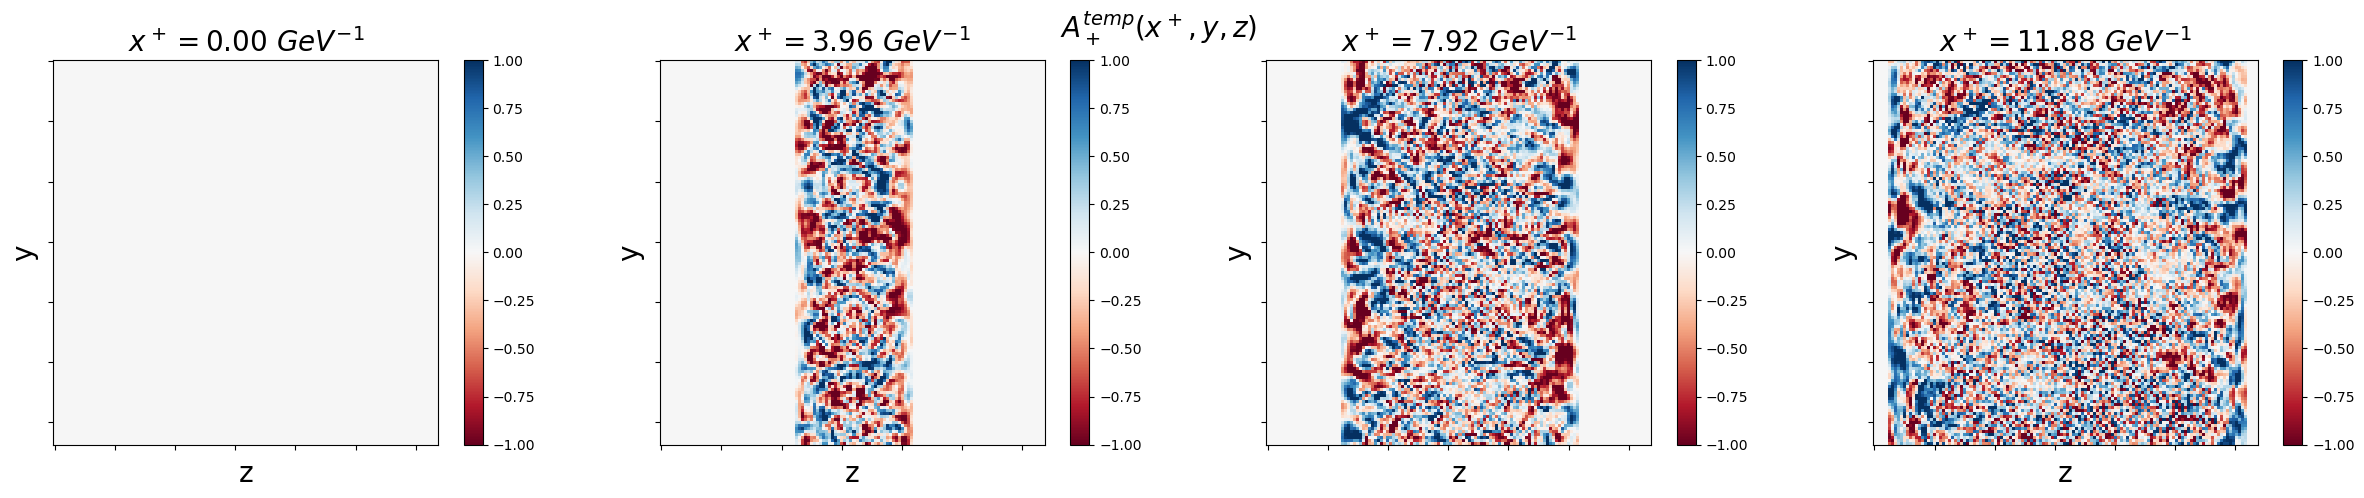

In [6]:
# We plot the temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    xplus = 20*t
    
    plot1 = axs[t].imshow(uplus_lc_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    axs[t].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc), fontsize=20)
    
# plt.savefig('temporal_gauge_fields')


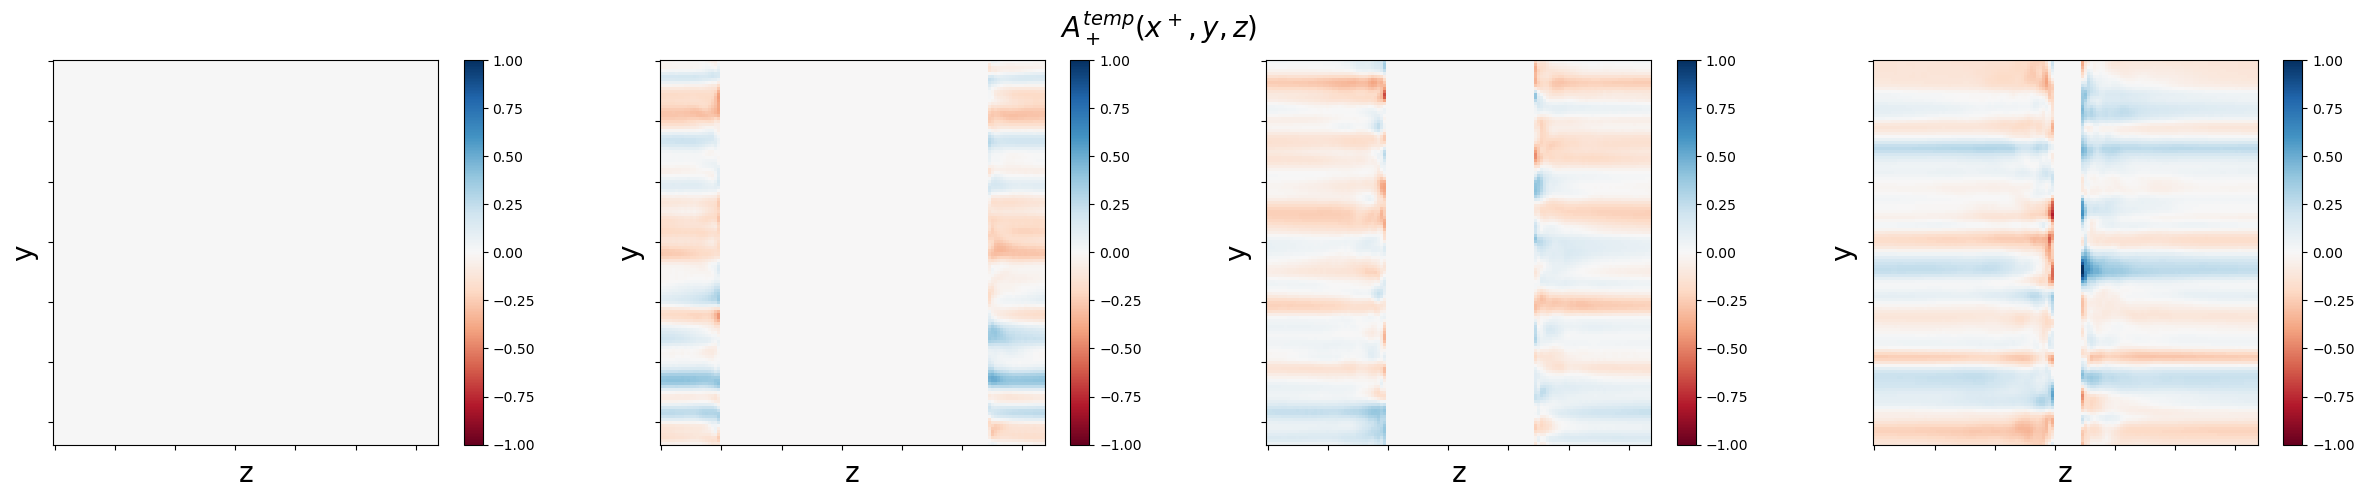

In [41]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(uplus_temp_reorder_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)

NameError: name 'uplus_lc_comp' is not defined

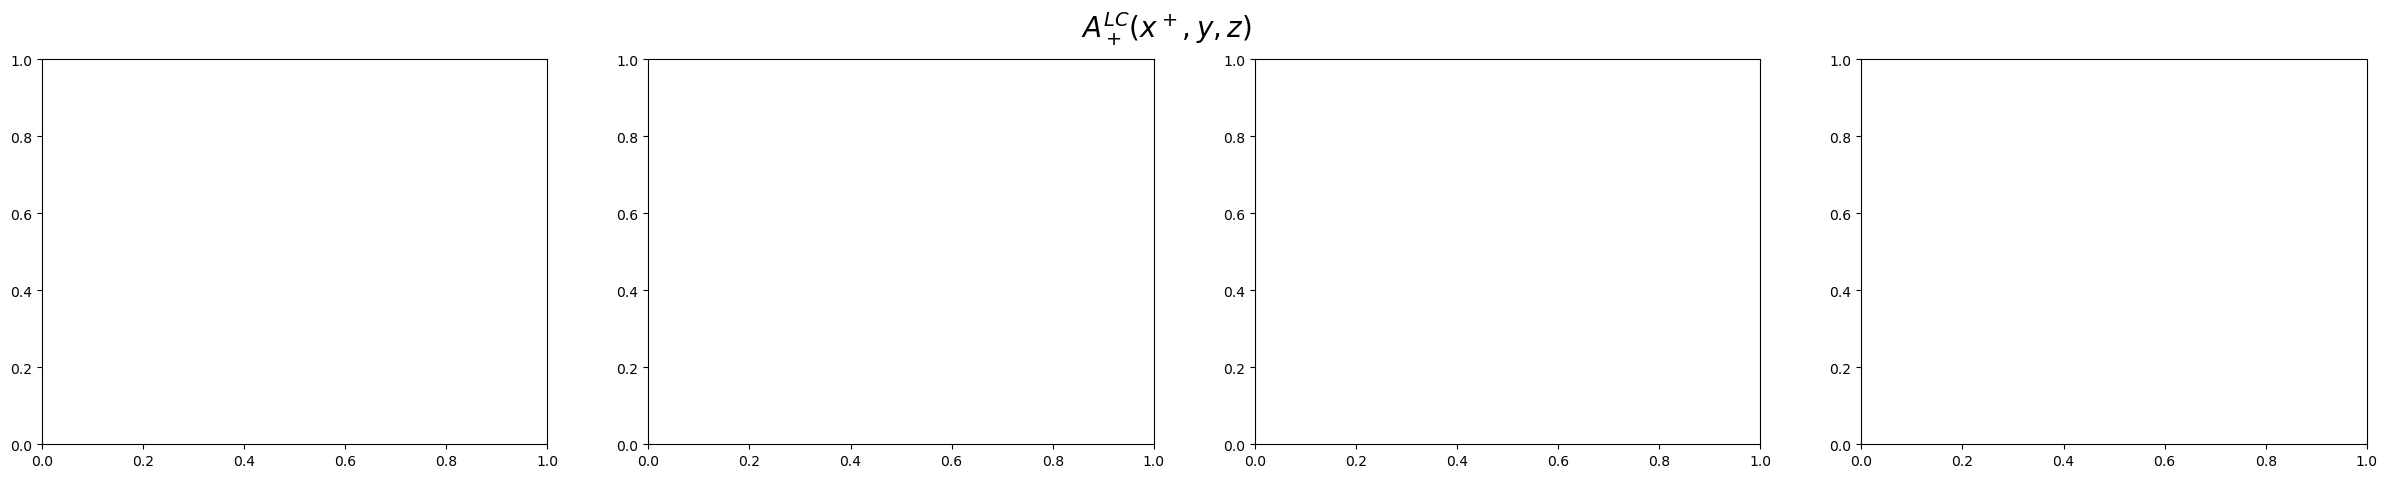

In [42]:
# We plot the LC gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{LC}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(uplus_lc_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('lc_gauge_fields')

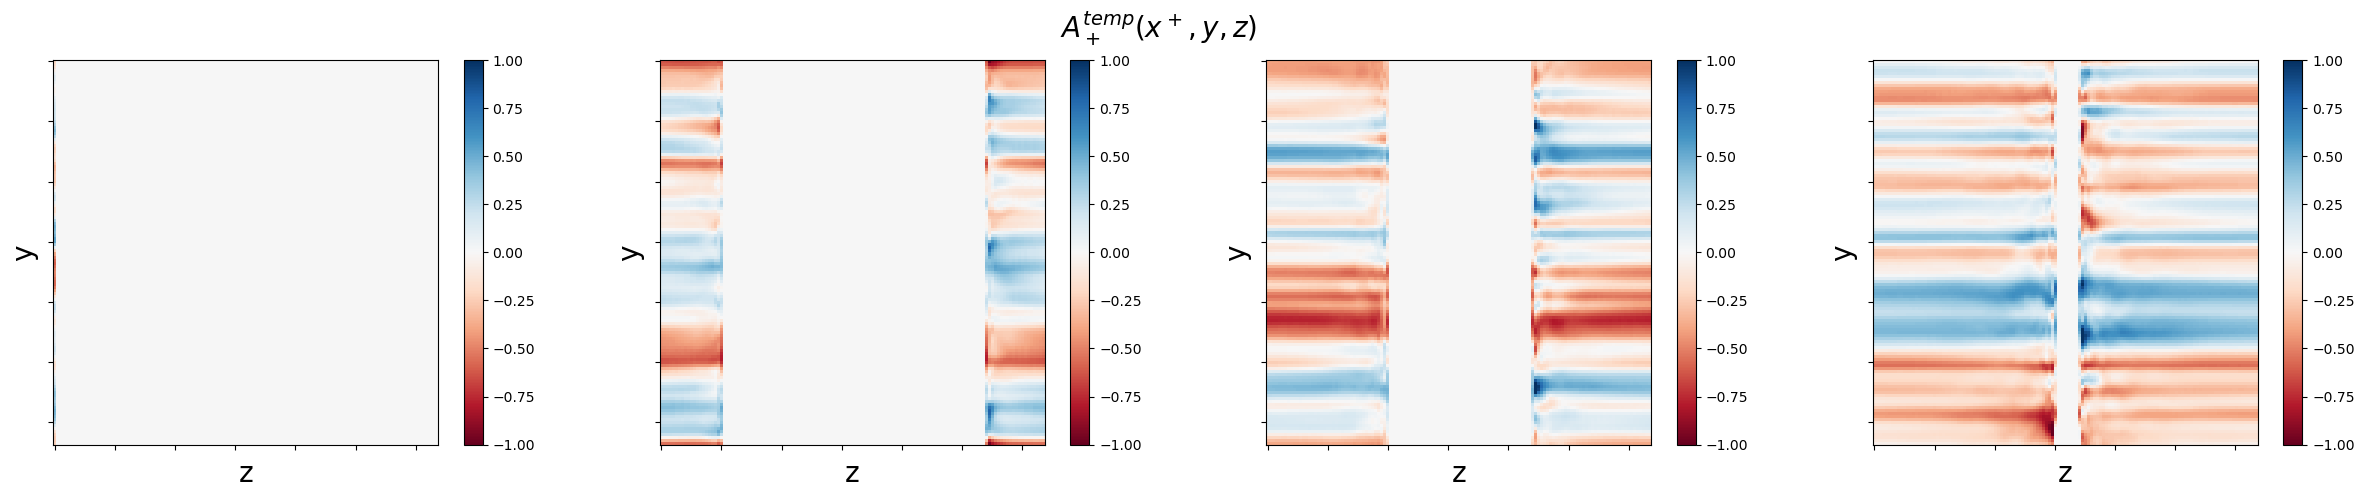

In [9]:
# We plot the reodered LC gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(uplus_lc_reorder_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
plt.savefig('temporal_gauge_fields')

# We plot the fields in Milne coordinates to compare

In [5]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128 
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [6]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.exact_lcgauge as lc_gauge

In [ ]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the necessary objects for the gauge transformations
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)
    
    # We create the objects where we will copy the simulated fields
    ux = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta = np.zeros((nplus, N*N, su. GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    with tqdm(total=maxt) as pbar:
        for tau in range(maxt):
                        
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            
            # When only copy the fields when the transverse and tau lattice match
            if tau%DTS == 0:
                xplus = tau//DTS
                
                # We copy the Glasma fields at every time step
                ux[xplus] = s.d_u1[:,0,:].copy()
                aeta[xplus] = s.aeta1.copy()
                
                lc.evolve_lc(xplus)
                

        
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()
        
    
    # We write the transformed fields in a dictionary
    output["nplus"] = nplus
    output["ux"] = ux
    output["aeta"] = aeta
    
    return output

In [8]:
# We perform the simulation

import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    ux = output['ux']
    aeta = output["aeta"]
    
    # np.save(os.path.join('exact_results_tempgauge', 'result_%i.npy' %n), uplus_temp_reorder)
    # np.save(os.path.join('exact_results', 'result_%i.npy' %n), uplus_lc_reorder)

Kernel xi: 0 d:  0 did not reach goal. check:  0.002049285151183226
Kernel xi: 0 d:  1 did not reach goal. check:  0.0018933455497369064
Kernel xi: 1 d:  0 did not reach goal. check:  0.002658531788000024
Kernel xi: 1 d:  1 did not reach goal. check:  0.002333468969490073
Kernel xi: 2 d:  0 did not reach goal. check:  0.0027397091042954944
Kernel xi: 2 d:  1 did not reach goal. check:  0.002854576270798489
Kernel xi: 3 d:  0 did not reach goal. check:  0.0030292591182611607
Kernel xi: 3 d:  1 did not reach goal. check:  0.0032920171384273806
Kernel xi: 4 d:  0 did not reach goal. check:  0.004358944619703176
Kernel xi: 4 d:  1 did not reach goal. check:  0.0027896858608638954
Kernel xi: 5 d:  0 did not reach goal. check:  0.006434674194147745
Kernel xi: 5 d:  1 did not reach goal. check:  0.0017567519300833083
Kernel xi: 6 d:  0 did not reach goal. check:  0.008035220954725168
Kernel xi: 6 d:  1 did not reach goal. check:  0.0006934207008940874
Kernel xi: 7 d:  0 did not reach goal. ch

100%|██████████| 512/512 [00:00<00:00, 538.68it/s]


In [10]:
ux_r = ux.reshape(nplus, N, N, su.GROUP_ELEMENTS)
aeta_r = aeta.reshape(nplus, N, N, su.GROUP_ELEMENTS)

ux_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, ux_r)
aeta_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, aeta_r)

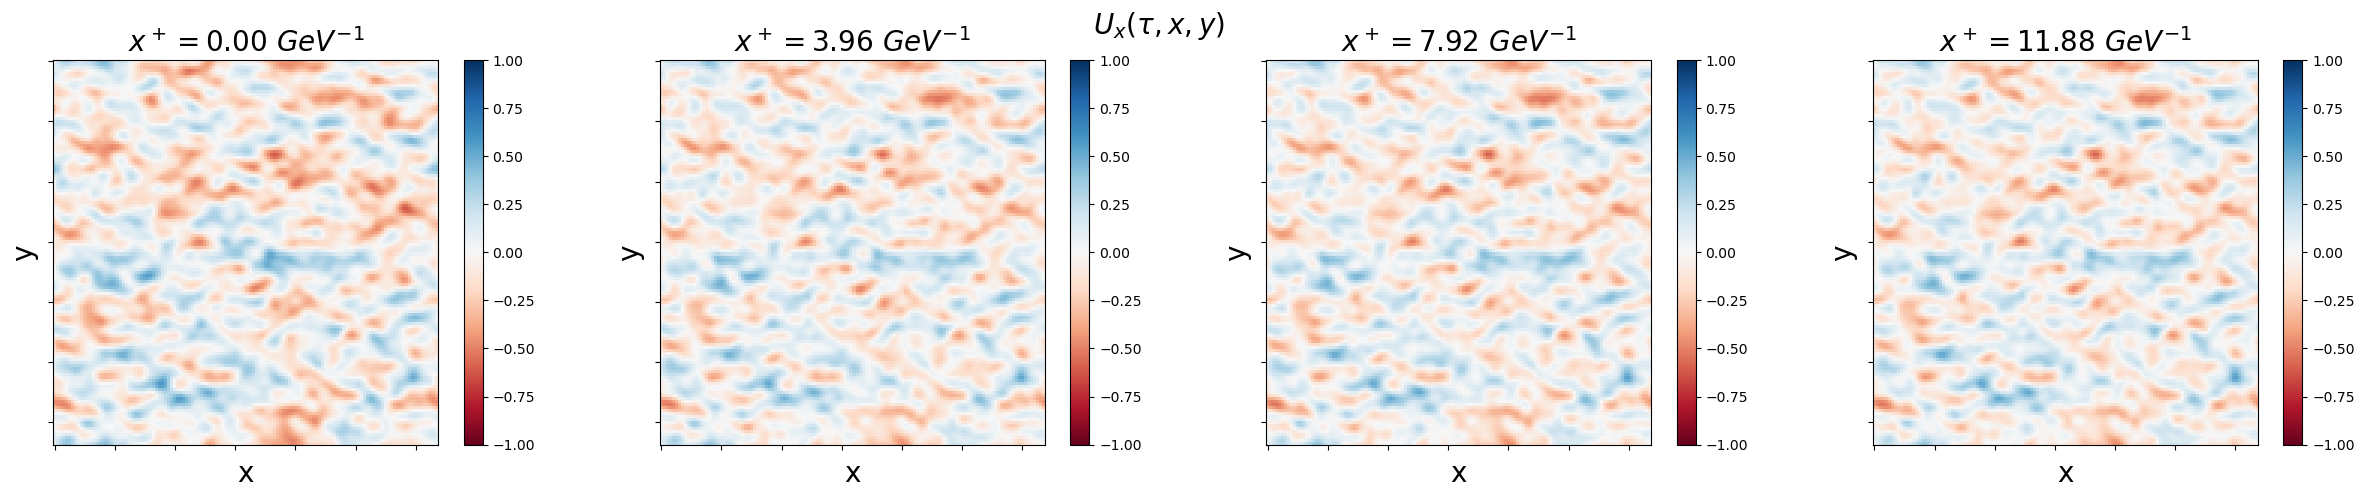

In [ ]:
# We plot the Ux links
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$U_x(\tau, x, y)$', fontsize=20)

for t in range(nplus//20 + 1): 
    xplus = 20*t
    
    plot1 = axs[t].imshow(ux_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('x', fontsize=20)
    axs[t].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc), fontsize=20)
    
# plt.savefig('temporal_gauge_fields')

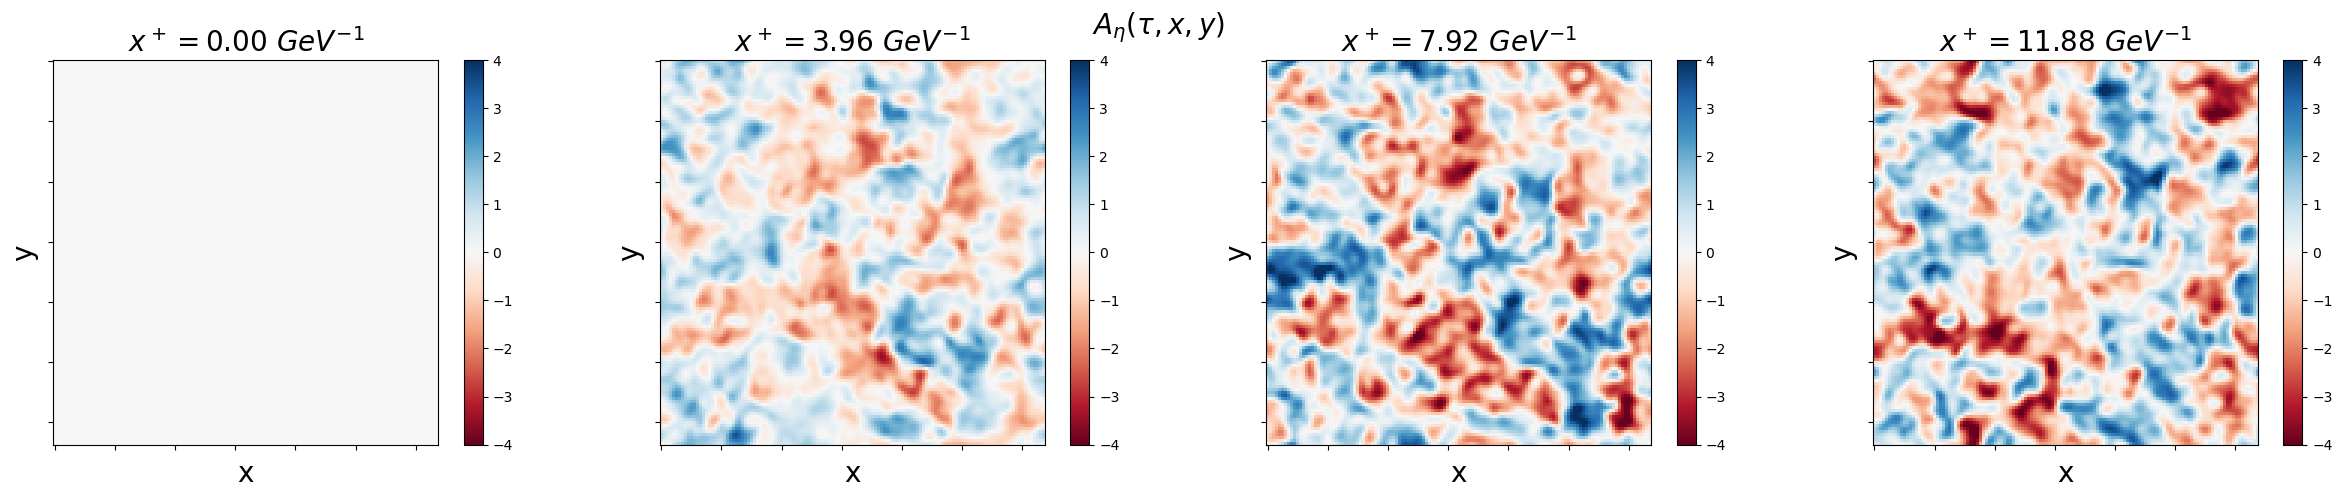

In [13]:
# We plot the Aeta fields
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_\eta(\tau, x, y)$', fontsize=20)

for t in range(nplus//20 + 1): 
    xplus = 20*t
    
    plot1 = axs[t].imshow(aeta_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-4, vmax=4) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('x', fontsize=20)
    axs[t].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc), fontsize=20)
    
# plt.savefig('temporal_gauge_fields')